# **Perbandingan Kinerja Klasifikasi menggunakan MLlib Apache Spark pada Efek Konsumsi Alcohol dan Rokok**



## **EDA (Exploratory Data Analysis)**

### Start building a Spark Session & Load Library

In [ ]:
# Import dasar PySpark untuk pengolahan data
from pyspark.sql import SparkSession # Membuat sesi Spark
from pyspark.sql import functions as F  # Fungsi-fungsi SQL
from pyspark.sql.functions import col, isnan, when, count, corr # Fungsi manipulasi kolom
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, MinMaxScaler  # Untuk preprocessing
from pyspark.sql.window import Window  # Operasi window
from pyspark.sql.types import IntegerType, FloatType # Tipe data

# Model klasifikasi PySpark
from pyspark.ml.classification import RandomForestClassifier as RF # Random Forest
from pyspark.ml.classification import GBTClassifier as GBT # Gradient Boosting
from pyspark.ml.classification import NaiveBayes #Naive Bayes
from xgboost.spark import SparkXGBClassifier # XGBoost untuk Spark

# Model tambahan non-Spark
from sklearn.neighbors import KNeighborsClassifier # KNN classifier
from sklearn.preprocessing import LabelEncoder # Encoding label
import xgboost as xgb # XGBoost standar

# Modul evaluasi model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # Evaluasi multiclass
from pyspark.mllib.evaluation import BinaryClassificationMetrics # Metrik klasifikasi biner
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Evaluasi klasifikasi biner
from pyspark.mllib.evaluation import MulticlassMetrics # Metrik multiclass

# Utilitas tambahan
import pandas as pd # Manipulasi data
import numpy as np # Operasi numerik
import matplotlib.pyplot as plt # Visualisasi
import seaborn as sns # Visualisasi statistik
import sklearn # Machine learning
import random # Generate angka random
import os # Operasi sistem
from sklearn.metrics import roc_curve, auc #Digunakan untuk memplot kurva ROC (Receiver Operating Characteristic)

In [ ]:
spark = SparkSession.builder \
    .appName("KlasifikasiNgombeAndNgudud") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()

  # .appName menetapkan nama aplikasi Spark
  # "spark.executor.memory", "2g" mengatur jumlah memori yang dialokasikan untuk setiap executor menjadi 2 gigabyte
  # "spark.driver.memory", "1g"Ini mengatur jumlah memori yang dialokasikan untuk driver menjadi 1 gigabyte.
  #  Konfigurasi ini menentukan jumlah instance executor yang akan digunakan adalah 2
  # .getOrCreate() memastikan bahwa hanya ada satu SparkSession yang aktif dalam aplikasi.

### Spark read

Note : Tolong untuk setiap re-run, please manually upload the .csv, kalau mengambil data dari drive & kaggle memakan waktu lama

Link : [Smoking and Drinking Dataset](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset/data)

In [ ]:
df=spark.read.csv('/content/smoking_driking_dataset_Ver01.csv',inferSchema=True,header=True)
df.show(5)

+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
| sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|Male| 35|   170|    75|     90.0|       1.0|        1.0|      1.0|       1.0|120.0|80.0| 99.0|    193.0|     48.0|    126.0|        92.0|      17.1|          1.0|             1.0|    21.0|    35.0|     40.0|             1.0|     Y|
|Male| 30|   180|    80|     89.0|       0.9|        1.2|      1.0| 

### Dataset Infos

In [ ]:
df.printSchema() # Menampilkan struktur schema

root
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- waistline: double (nullable = true)
 |-- sight_left: double (nullable = true)
 |-- sight_right: double (nullable = true)
 |-- hear_left: double (nullable = true)
 |-- hear_right: double (nullable = true)
 |-- SBP: double (nullable = true)
 |-- DBP: double (nullable = true)
 |-- BLDS: double (nullable = true)
 |-- tot_chole: double (nullable = true)
 |-- HDL_chole: double (nullable = true)
 |-- LDL_chole: double (nullable = true)
 |-- triglyceride: double (nullable = true)
 |-- hemoglobin: double (nullable = true)
 |-- urine_protein: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- SGOT_AST: double (nullable = true)
 |-- SGOT_ALT: double (nullable = true)
 |-- gamma_GTP: double (nullable = true)
 |-- SMK_stat_type_cd: double (nullable = true)
 |-- DRK_YN: string (nullable = true)



### Rincian Dataset
- **Sex**: Jenis kelamin - laki-laki, perempuan.
- **Age**: Usia - dibulatkan ke angka terdekat 5 tahun.

- **Height**: Tinggi badan - dibulatkan ke angka terdekat 5 cm [cm].

- **Weight**: Berat badan [kg].

- **Waistline**: Lingkar pinggang.

- **Sight_left**: Ketajaman penglihatan mata kiri - kolom ini menunjukkan seberapa baik mata kiri melihat, di mana penglihatan sempurna = 1.0.

- **Sight_right**: Ketajaman penglihatan mata kanan - kolom ini menunjukkan seberapa baik mata kanan melihat, di mana penglihatan sempurna = 1.0.

- **Hear_left**: Pendengaran telinga kiri - 1 (normal), 2 (abnormal).
  
- **Hear_right**: Pendengaran telinga kanan - 1 (normal), 2 (abnormal).

- **SBP**: Tekanan darah sistolik [mmHg].

- **DBP**: Tekanan darah diastolik [mmHg].

- **BLDS**: Gula darah puasa (FSG) [mg/dL].

- **Tot_chole**: Total kolesterol [mg/dL].

- **HDL_chole**: Kolesterol HDL [mg/dL] - satu-satunya fraksi kolesterol yang disebut "baik" atau "berguna".

- **LDL_chole**: Kolesterol LDL [mg/dL].

- **Triglyceride**: Trigliserida [mg/dL].

- **Hemoglobin**: Kadar hemoglobin [g/dL].

- **Urine_protein**: Kadar protein dalam urine - 1 (-), 2 (+/-), 3 (+1), 4 (+2), 5 (+3), 6 (+4).

- **Serum_creatinine**: Kadar kreatinin serum (darah) [mg/dL].

- **SGOT_AST**: SGOT (Glutamate-oxaloacetate transaminase) dan AST (Aspartate transaminase) [IU/L].

- **SGOT_ALT**: ALT (Alanine transaminase) [IU/L].

- **Gamma_GTP**: y-glutamyl transpeptidase [IU/L].

- **SMK_stat_type_cd**: Status merokok - 1 (tidak pernah), 2 (dulu merokok tetapi berhenti), 3 (masih merokok).

- **DRK_YN**: Status peminum alkohol atau tidak (Y - Ya / N - Tidak).

### Dataset Describe

In [ ]:
df.describe().show() #Menampilkan ringkasan statistik untuk semua kolom numerik

+-------+------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------+
|summary|   sex|               age|            height|            weight|         waistline|        sight_left|       sight_right|        hear_left|         hear_right|               SBP|              DBP|              BLDS|         tot_chole|         HDL_chole|         LDL_chole|      triglyceride|        hemoglobin|     urine_protein|  serum_creatinine|          SGOT_AST|          SGOT_ALT|         gamma_GTP|  SMK_stat_type_cd|DRK_YN|
+-------+------+------------------+------------------+------------------+------------------+------------------+-------

1. **'count'** : Jumlah data/baris yang tidak null untuk setiap kolom
2. **'mean'** : Nilai rata-rata (average) dari setiap kolom numerik
3. **'stddev'** : Standar deviasi, mengukur seberapa bervariasi/tersebar data dari nilai rata-ratanya
  * Jika stddev **kecil**: data cenderung dekat dengan mean
  * Jika stddev **besar**: data lebih tersebar jauh dari mean
4. **'min'** : Nilai terendah dalam kolom tersebut
5. **'max'** : Nilai tertinggi dalam kolom tersebut

### Check null value at every column

In [ ]:
# memeriksa nilai null di setiap kolom DataFrame menggunakan PySpark
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+------+------+---------+----------+-----------+---------+----------+---+---+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|SBP|DBP|BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+---+---+------+------+---------+----------+-----------+---------+----------+---+---+----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|  0|  0|     0|     0|        0|         0|          0|        0|         0|  0|  0|   0|        0|        0|        0|           0|         0|            0|               0|       0|       0|        0|               0|     0|
+---+---+------+------+---------+----------+-----------+---------+----------+---+---+---

### Check unique values for each columns

In [ ]:
#menghitung dan mencetak jumlah nilai unik untuk setiap kolom dalam DataFrame
for col_name in df.columns:
    unique_count = df.select(col_name).distinct().count()
    print(f"Column '{col_name}' has {unique_count} unique values")

Column 'sex' has 2 unique values
Column 'age' has 14 unique values
Column 'height' has 13 unique values
Column 'weight' has 24 unique values
Column 'waistline' has 737 unique values
Column 'sight_left' has 24 unique values
Column 'sight_right' has 24 unique values
Column 'hear_left' has 2 unique values
Column 'hear_right' has 2 unique values
Column 'SBP' has 171 unique values
Column 'DBP' has 127 unique values
Column 'BLDS' has 498 unique values
Column 'tot_chole' has 474 unique values
Column 'HDL_chole' has 223 unique values
Column 'LDL_chole' has 432 unique values
Column 'triglyceride' has 1657 unique values
Column 'hemoglobin' has 190 unique values
Column 'urine_protein' has 6 unique values
Column 'serum_creatinine' has 183 unique values
Column 'SGOT_AST' has 568 unique values
Column 'SGOT_ALT' has 594 unique values
Column 'gamma_GTP' has 940 unique values
Column 'SMK_stat_type_cd' has 3 unique values
Column 'DRK_YN' has 2 unique values


### Boxplot from each column to identify any outliers

In [ ]:
def plot_boxplots(dataframe):
    # Menggunakan list comprehension untuk mendapatkan nama-nama kolom yang bertipe numerik (baik int maupun double) dari DataFrame PySpark.
    num_columns = [item[0] for item in dataframe.dtypes if item[1].startswith('int') or item[1].startswith('double')]
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2
    # Membuat subplots dengan jumlah baris rows dan 2 kolom.
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, 20))
    # figsize=(20, 20) menentukan ukuran keseluruhan dari figure.

    # Mengonversi DataFrame PySpark menjadi DataFrame Pandas untuk memudahkan plotting dengan Seaborn, yang bekerja lebih baik dengan Pandas.
    pandas_df = dataframe.toPandas()

    # Mengiterasi setiap kolom numerik yang ditemukan.
    for i, column in enumerate(num_columns):
        row = i // 2 # row menentukan baris subplot
        col = i % 2 # col menentukan kolom subplot.
        ax = axes[row, col] # Mendapatkan subplot yang sesuai dari array axes.
        sns.boxplot(x=pandas_df[column], ax=ax)  # menentukan data yang akan diplot.
        ax.set_title(f"Boxplot of {column}") # Menetapkan judul dan label sumbu x untuk setiap subplot.
        ax.set_xlabel(column)

    plt.tight_layout() # Menyesuaikan tata letak subplot agar tidak saling tumpang tindih.
    plt.show()

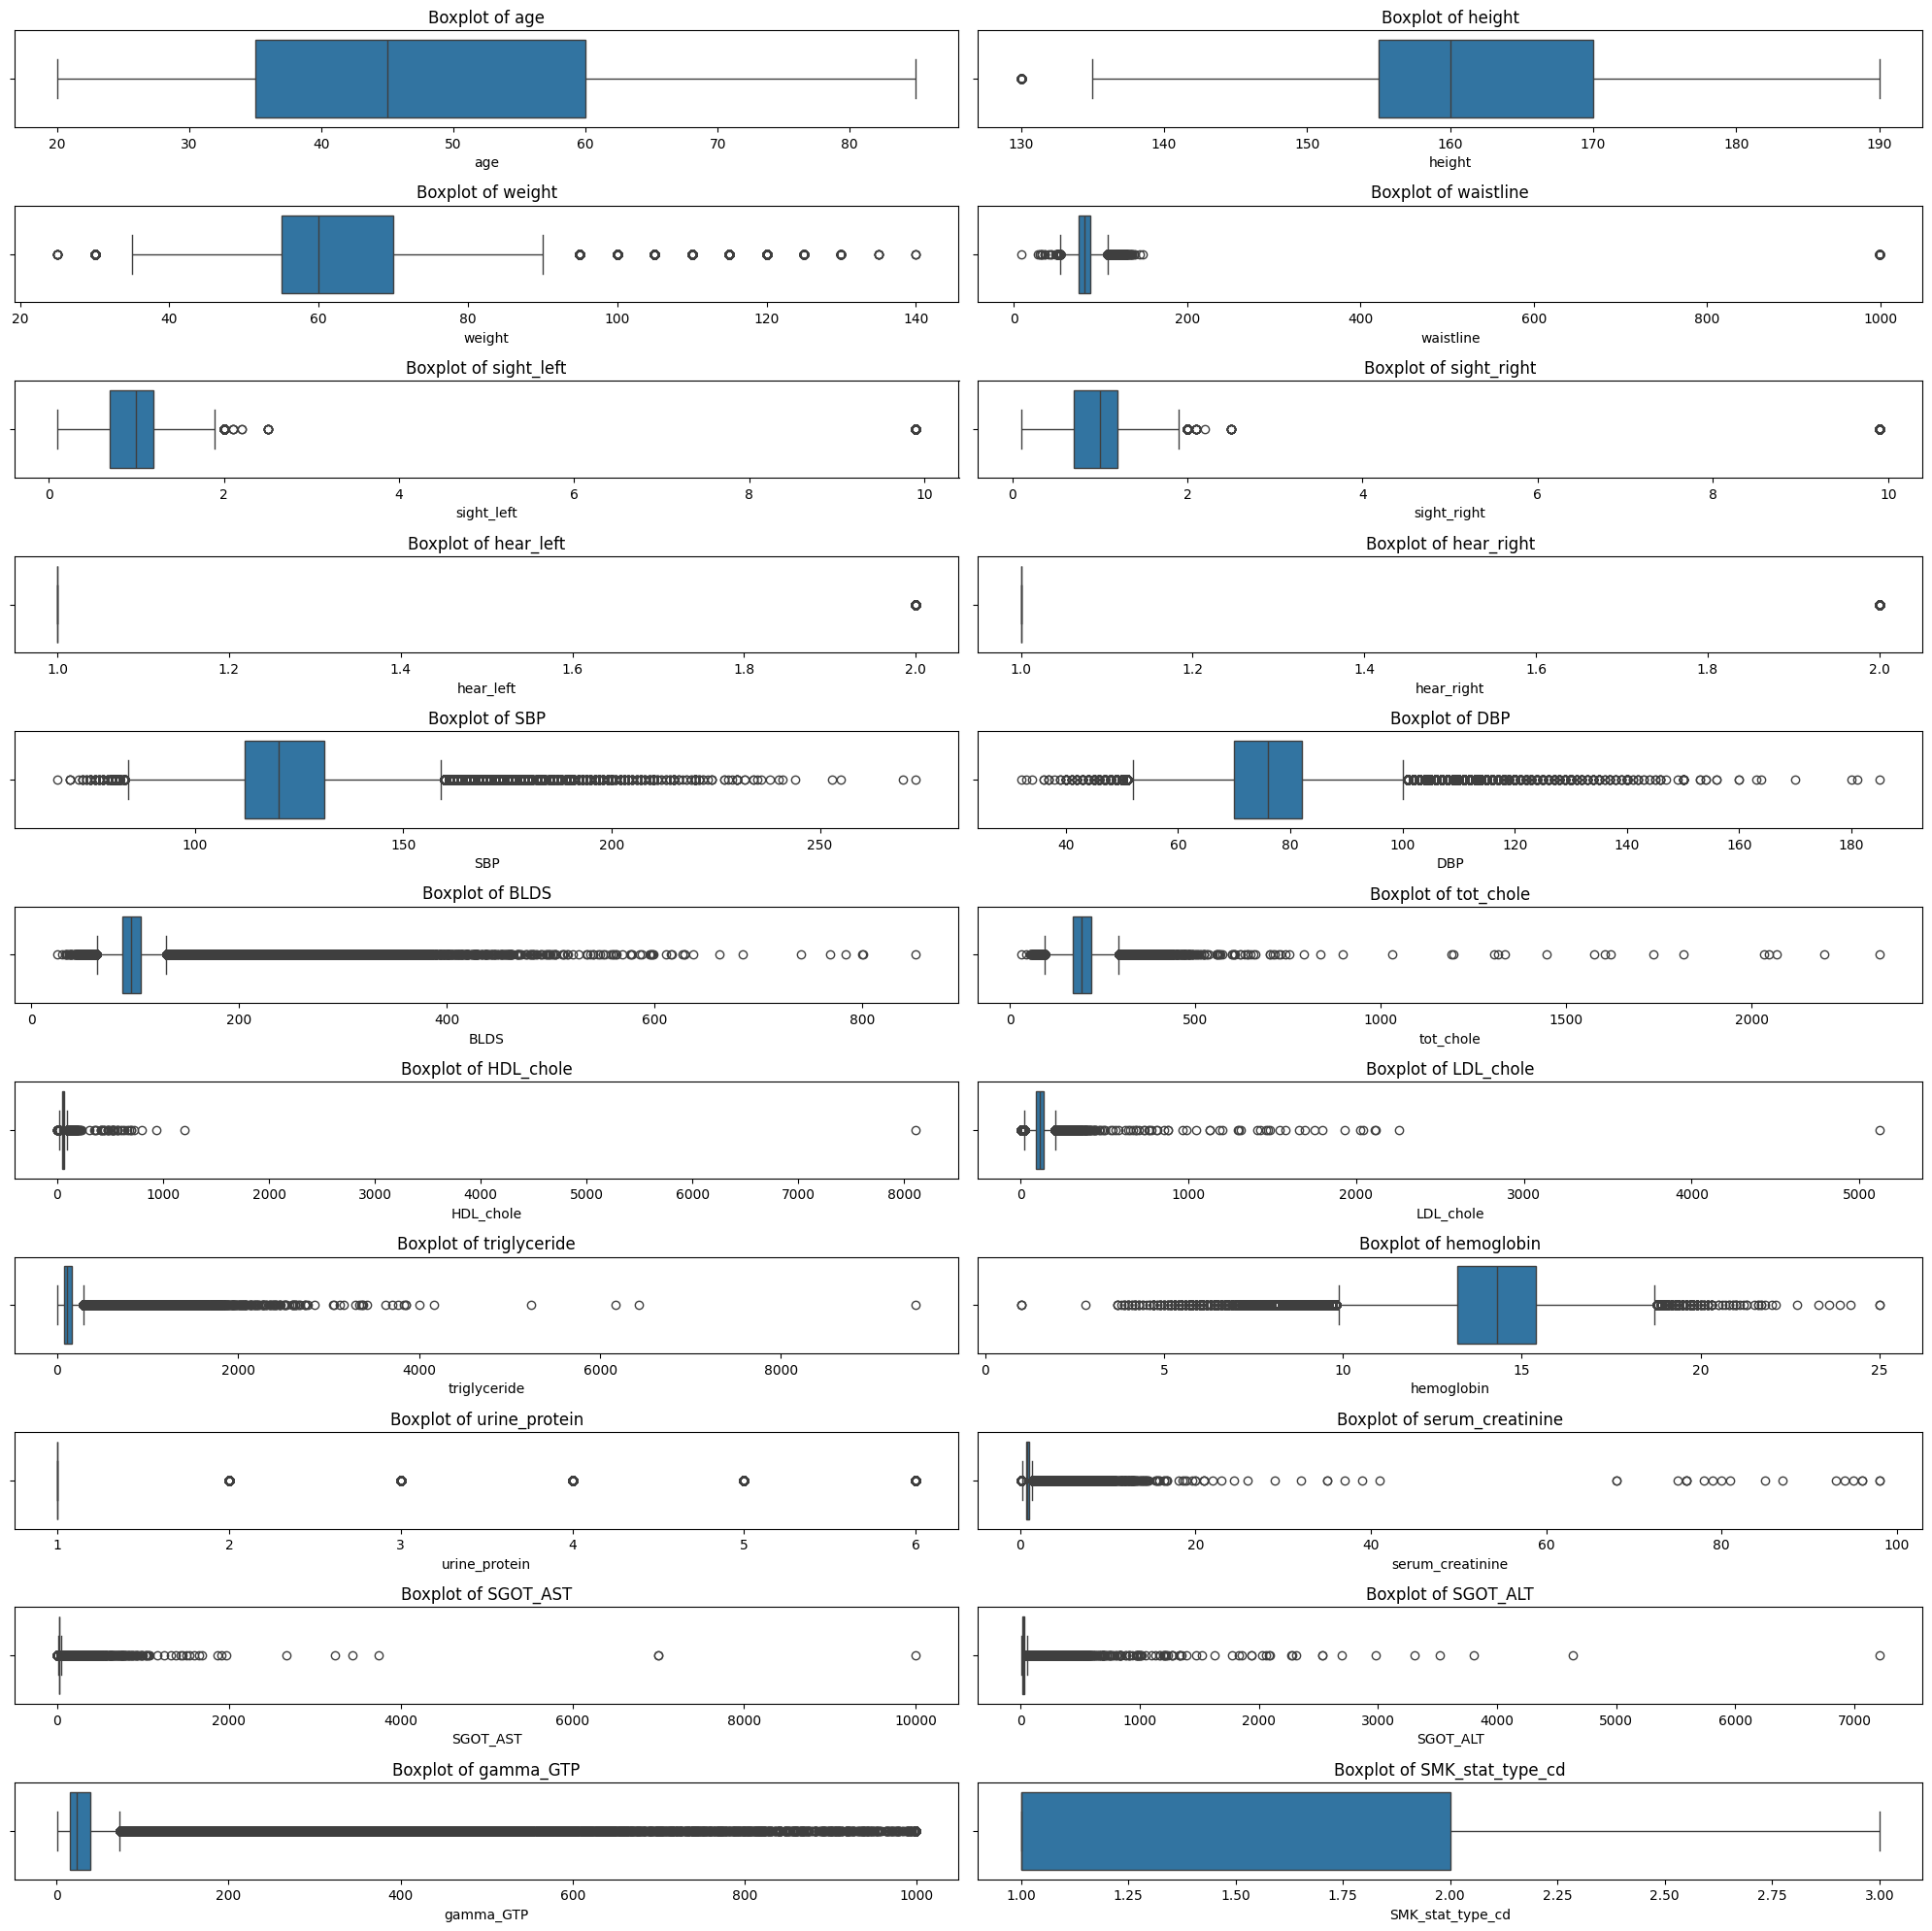

In [ ]:
plot_boxplots(df)

### Mengubah representasi data numerik & object menjadi lebih deskriptif

In [ ]:
# Use the withColumn and replace functions from PySpark
sex_status = df.withColumn("sex",
when(df["sex"] == 0, "Male")# 0 untuk Male
.when(df["sex"] == 1, "Female")# 1 untuk Female
.otherwise(df["sex"])# Nilai akan tetap dipertahankan seperti aslinya (tidak diubah)
)

smoking_status = df.withColumn(
"SMK_stat_type_cd",
when(df["SMK_stat_type_cd"] == 1, "never")#1 nilainya diganti menjadi "never" (tidak pernah merokok).
.when(df["SMK_stat_type_cd"] == 2, "used to smoke but quit")#2 nilainya diganti menjadi "used to smoke but quit" (mantan perokok).
.when(df["SMK_stat_type_cd"] == 3, "still smoke")#  3, nilainya diganti menjadi "still smoke" (masih merokok).
.otherwise(df["SMK_stat_type_cd"])# Nilai akan tetap dipertahankan seperti aslinya (tidak diubah) jika bukan 1, 2, atau 3
)

drinking_status = df.withColumn(
"DRK_YN",
when(df["DRK_YN"] == "N", "Not Drinker")#"N" nilainya diganti menjadi "Not Drinker".
.when(df["DRK_YN"] == "Y", "Drinker")#"Y" nilainya diganti menjadi "Drinker".
.otherwise(df["DRK_YN"])# Nilai akan tetap dipertahankan seperti aslinya (tidak diubah) jika bukan N atau Y
)

### Jumlah kemunculan (frekuensi) masing-masing nilai unik dalam kolom DRK_YN

In [ ]:
# Mengelompokkan DataFrame drinking_status berdasarkan nilai-nilai dalam kolom DRK_YN
drinking_counts = drinking_status.groupBy("DRK_YN").agg(count("*").alias("count"))

# Display the results
drinking_counts.show()

+-----------+------+
|     DRK_YN| count|
+-----------+------+
|Not Drinker|495858|
|    Drinker|495488|
+-----------+------+



### Jumlah kemunculan (frekuensi) masing-masing nilai unik dalam kolom SMK_stat_type_cd

In [ ]:
# Mengelompokkan DataFrame smoking_status berdasarkan nilai-nilai dalam kolom SMK_stat_type_cd
smoking_counts = smoking_status.groupBy("SMK_stat_type_cd").agg(count("*").alias("count"))

# Display the results
smoking_counts.show()

+--------------------+------+
|    SMK_stat_type_cd| count|
+--------------------+------+
|used to smoke but...|174951|
|               never|602441|
|         still smoke|213954|
+--------------------+------+



### Pie Chart

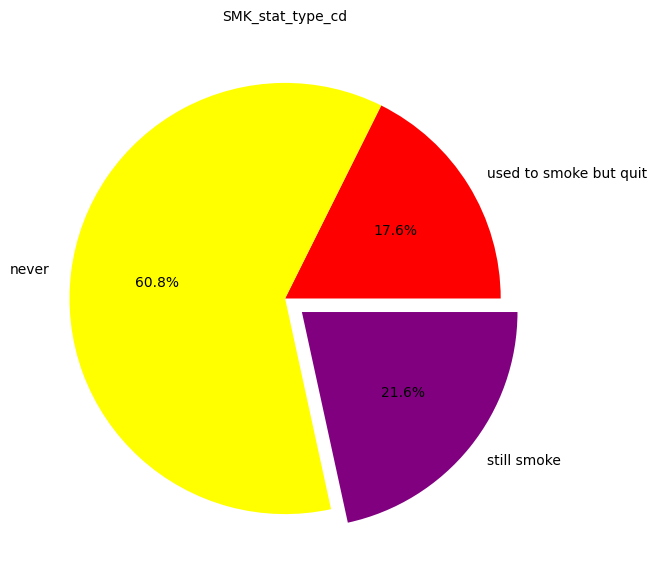

In [ ]:
# Group by 'SMK_stat_type_cd' and count occurrences
value_counts = smoking_status.groupBy("SMK_stat_type_cd").agg(F.count("*").alias("count"))

# Convert to Pandas DataFrame for plotting
pandas_df = value_counts.toPandas()

# Extract values and labels for the pie chart
values = pandas_df['count'].values
labels = pandas_df['SMK_stat_type_cd'].values

# Define colors and explode values
colors = ['red', 'yellow', 'purple']
explode = [0, 0, 0.1]

# Create and display the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('SMK_stat_type_cd', color='black', fontsize=10)
plt.show()

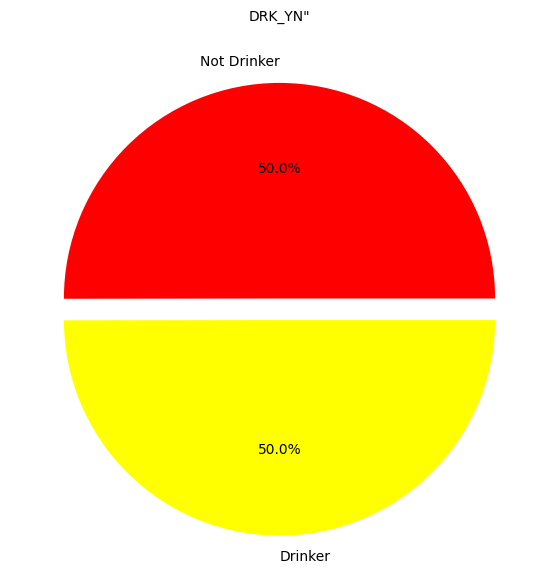

In [ ]:
# Group by 'DRK_YN' and count occurrences
value_counts = drinking_status.groupBy("DRK_YN").agg(F.count("*").alias("count"))

# Convert to Pandas DataFrame for plotting
pandas_df = value_counts.toPandas()

# Extract values and labels for the pie chart
values = pandas_df['count'].values
labels = pandas_df['DRK_YN'].values

# Define colors and explode values
colors = ['red', 'yellow']
explode = [0, 0.1]

# Create and display the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('DRK_YN"', color='black', fontsize=10)
plt.show()

### Bar Chart

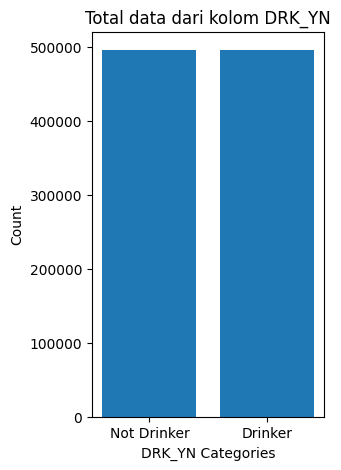

In [ ]:
# Group by 'DRK_YN' and count occurrences
counts = drinking_status.groupBy("DRK_YN").agg(count("*").alias("count")).toPandas()

# Create a bar chart
plt.figure(figsize=(3, 5))  # Optional: Adjust the figure size
plt.bar(counts['DRK_YN'], counts['count'])  # Use the column names from the Pandas DataFrame
plt.xlabel("DRK_YN Categories")
plt.ylabel("Count")
plt.title("Total data dari kolom DRK_YN")
plt.show()

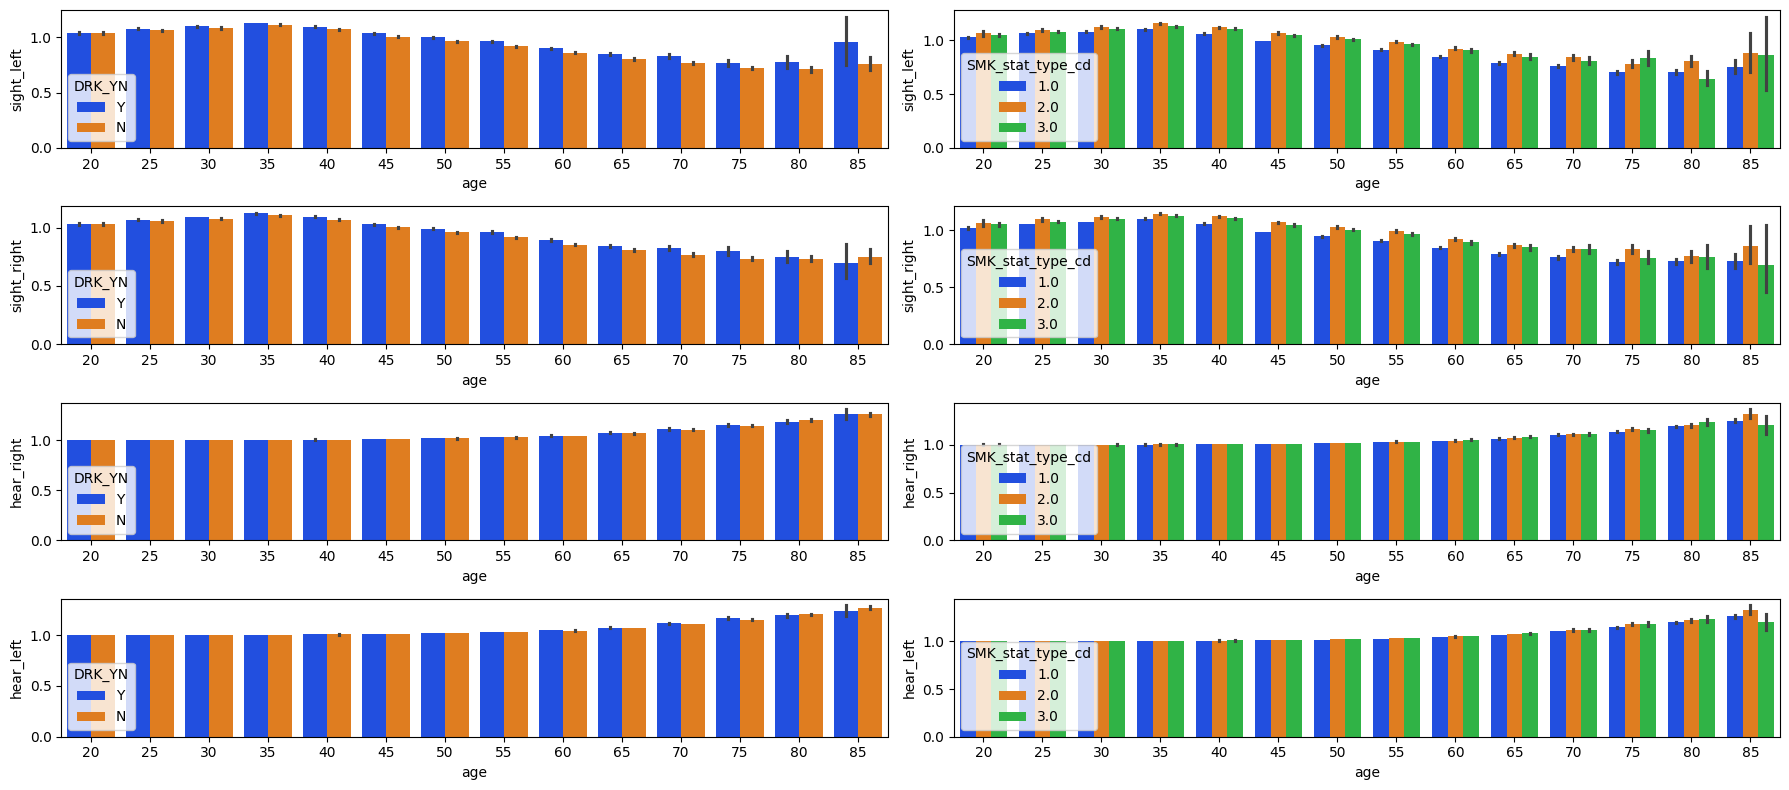

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(18,8))
pandas_df = df.toPandas()

metrics = ['sight_left', 'sight_right', 'hear_right', 'hear_left']
categories = ['DRK_YN', 'SMK_stat_type_cd']

for i, metric in enumerate(metrics):
   for j, category in enumerate(categories):
       sns.barplot(data=pandas_df, x='age', y=metric, hue=category,
                  palette='bright', ax=axes[i,j])

plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

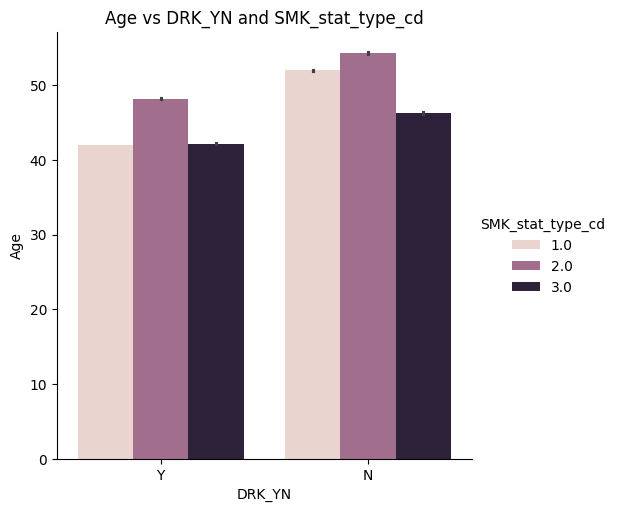

In [ ]:
plt.figure(figsize=(12,7))
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()
sns.catplot(y="age", x="DRK_YN", hue="SMK_stat_type_cd", data=pandas_df, kind="bar") # Use the Pandas DataFrame here
plt.xlabel("DRK_YN")
plt.ylabel("Age")
plt.title("Age vs DRK_YN and SMK_stat_type_cd")
plt.show()

### Heatmap correlation ( Before Dropping The Outliers )

In [ ]:
numerical_variables = [
    col_name for col_name, col_type in df.dtypes
    if col_type in ['int', 'double']  # Adjust these types as needed
]

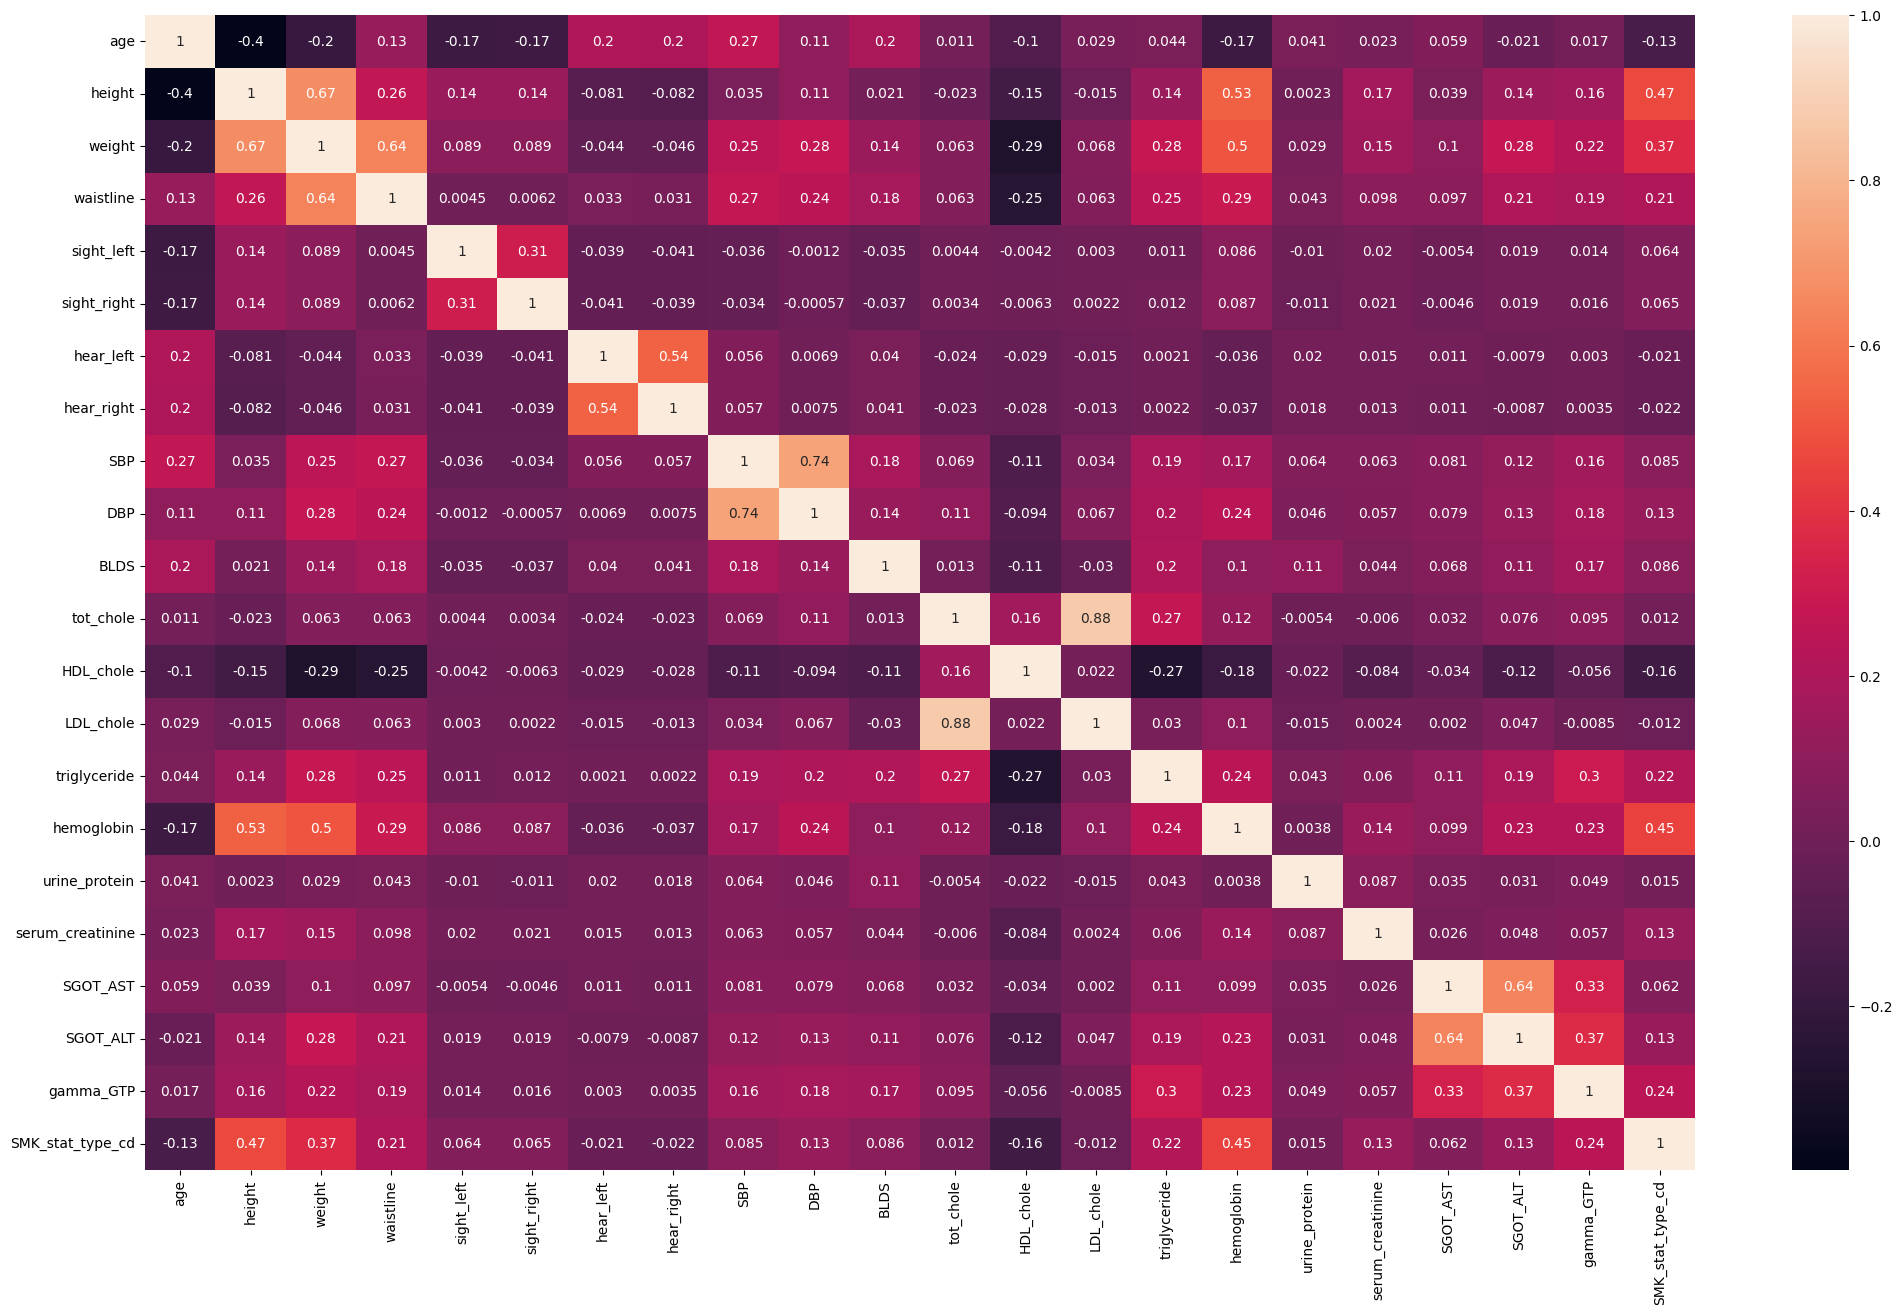

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame for visualization with seaborn
numeric_df = df.select(numerical_variables).toPandas()

# Calculate the correlation matrix using Pandas corr() method
correlation_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## **Data Pre-processing**

### Check Data

In [ ]:
df.show(5)

+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
| sex|age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|
+----+---+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+
|Male| 35|   170|    75|     90.0|       1.0|        1.0|      1.0|       1.0|120.0|80.0| 99.0|    193.0|     48.0|    126.0|        92.0|      17.1|          1.0|             1.0|    21.0|    35.0|     40.0|             1.0|     Y|
|Male| 30|   180|    80|     89.0|       0.9|        1.2|      1.0| 

### Encoding

In [ ]:
# Membuat StringIndexer untuk kedua kolom
encoders = [
    StringIndexer(inputCol=col, outputCol=f"{col}_encoded", handleInvalid="keep")
    for col in ["DRK_YN", "sex"]
]

# Menerapkan encoding untuk setiap kolom
for encoder in encoders:
    # Fit dan transform data
    df = encoder.fit(df).transform(df)

    # Menampilkan hasil encoding
    col_name = encoder.getInputCol()
    print(f"Count of {col_name}:")
    df.groupBy(f"{col_name}_encoded").count().orderBy(f"{col_name}_encoded").show()

    # Drop kolom asli dan rename kolom hasil encoding
    df = df.drop(col_name).withColumnRenamed(f"{col_name}_encoded", col_name)

Count of DRK_YN:
+--------------+------+
|DRK_YN_encoded| count|
+--------------+------+
|           0.0|495858|
|           1.0|495488|
+--------------+------+

Count of sex:
+-----------+------+
|sex_encoded| count|
+-----------+------+
|        0.0|526415|
|        1.0|464931|
+-----------+------+



### Remove Outliers

* Menggunakan metode IQR yang robust
* Mempertahankan data dengan clipping, bukan menghapus
* Lebih conservative dalam penanganan outliers

In [ ]:
def remove_outliers_pyspark(df, columns, k=1.5):
    df_clean = df
    for column in columns:
        # Hitung Q1 dan Q3
        quantiles = df_clean.selectExpr(
            f'percentile_approx({column}, array(0.25, 0.75), 10000) as quantiles'
        ).collect()[0]['quantiles']

        q1 = quantiles[0]
        q3 = quantiles[1]
        iqr = q3 - q1

        # Terapkan batas
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr

        # Filter data
        df_clean = df_clean.withColumn(
            column,
            F.when(F.col(column) < lower_bound, lower_bound)
             .when(F.col(column) > upper_bound, upper_bound)
             .otherwise(F.col(column))
        )

    return df_clean

df_clean = remove_outliers_pyspark(df, numerical_variables)

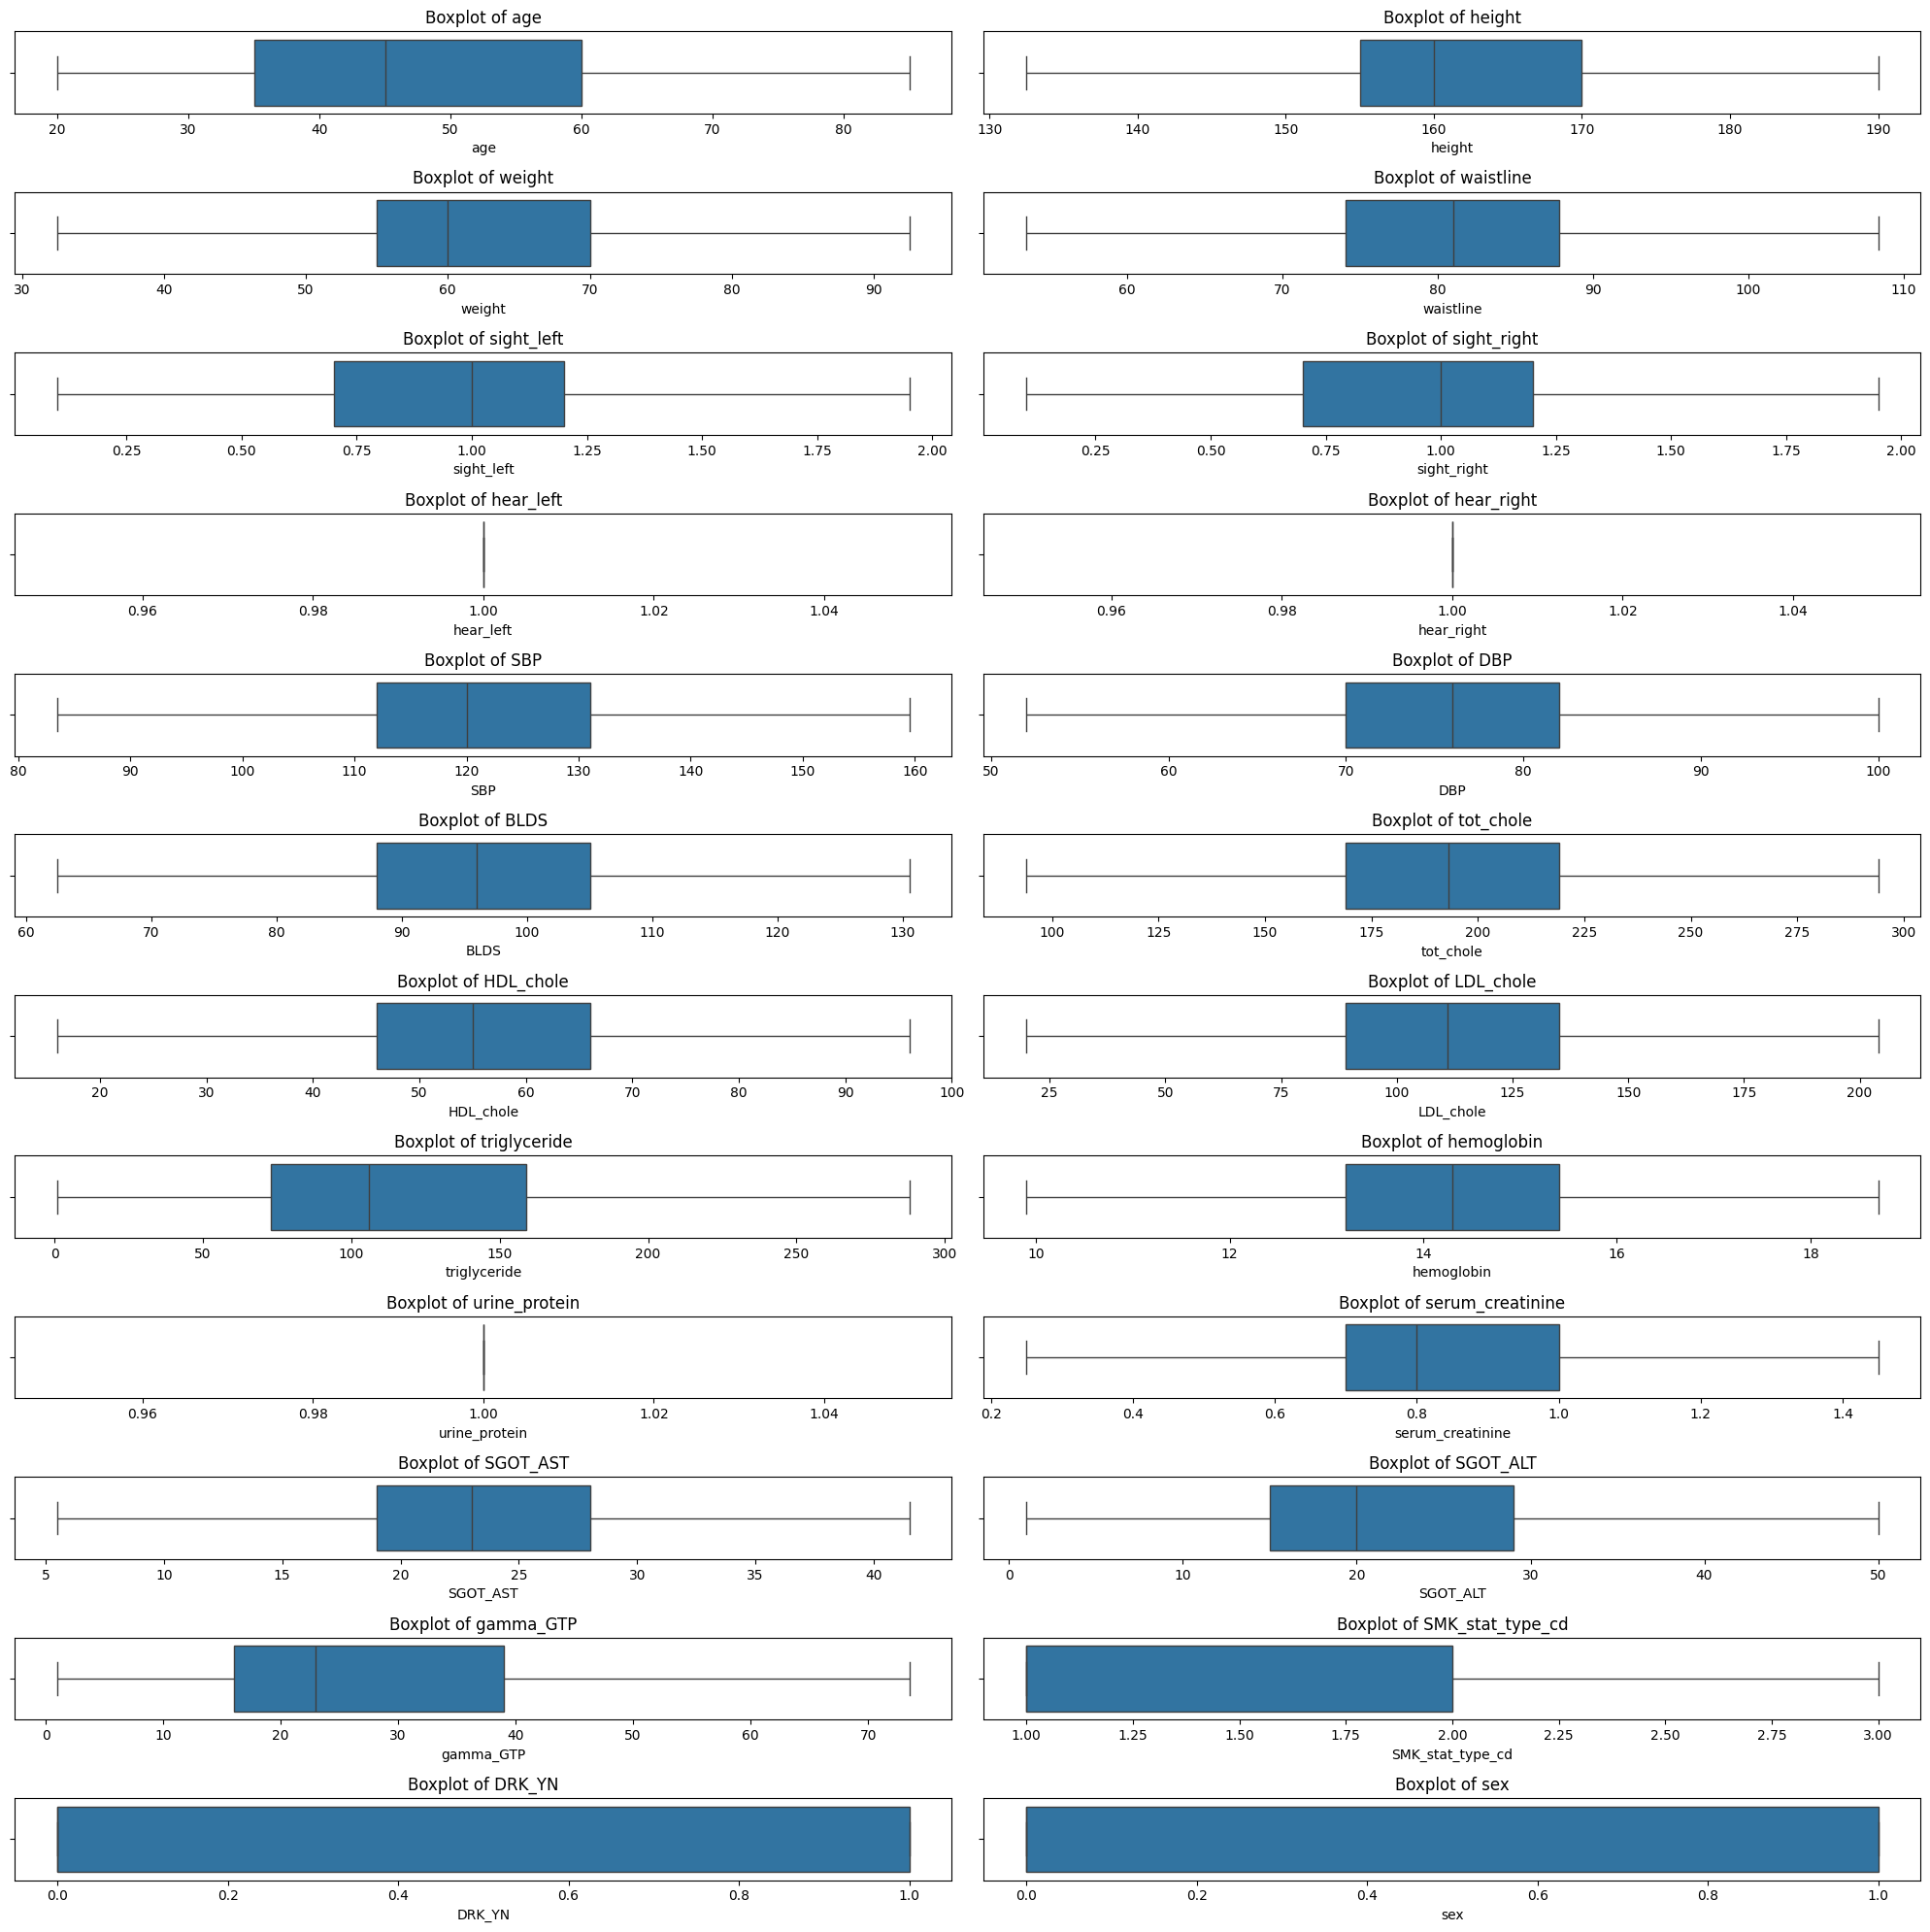

In [ ]:
plot_boxplots(df_clean)

### Check Duplicated Rows and Drop Them

In [ ]:
num_duplicates = df_clean.count() - df_clean.dropDuplicates().count()
print(f"Total baris duplikat: {num_duplicates}")

df = df_clean.dropDuplicates()

print(f"Sisa baris : {df.count()}")

Total baris duplikat: 26
Sisa baris : 991320


### Drop value that are inf

Mengganti nilai np.inf (tak hingga positif) dan -np.inf (tak hingga negatif) dalam DataFrame dengan np.nan (nilai yang mewakili "missing" atau "NaN").

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan) # Assign the result back to df
# Check for missing values and fill or drop them
df = df.dropna() # Assign the result back to df

### Check Shape

In [ ]:
# Get the number of rows
num_rows = df_clean.count()

# Get the number of columns
num_cols = len(df_clean.columns)

# Print the shape (rows, columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (991346, 24)


### Heatmap Correlation ( Cleaned )

<Axes: >

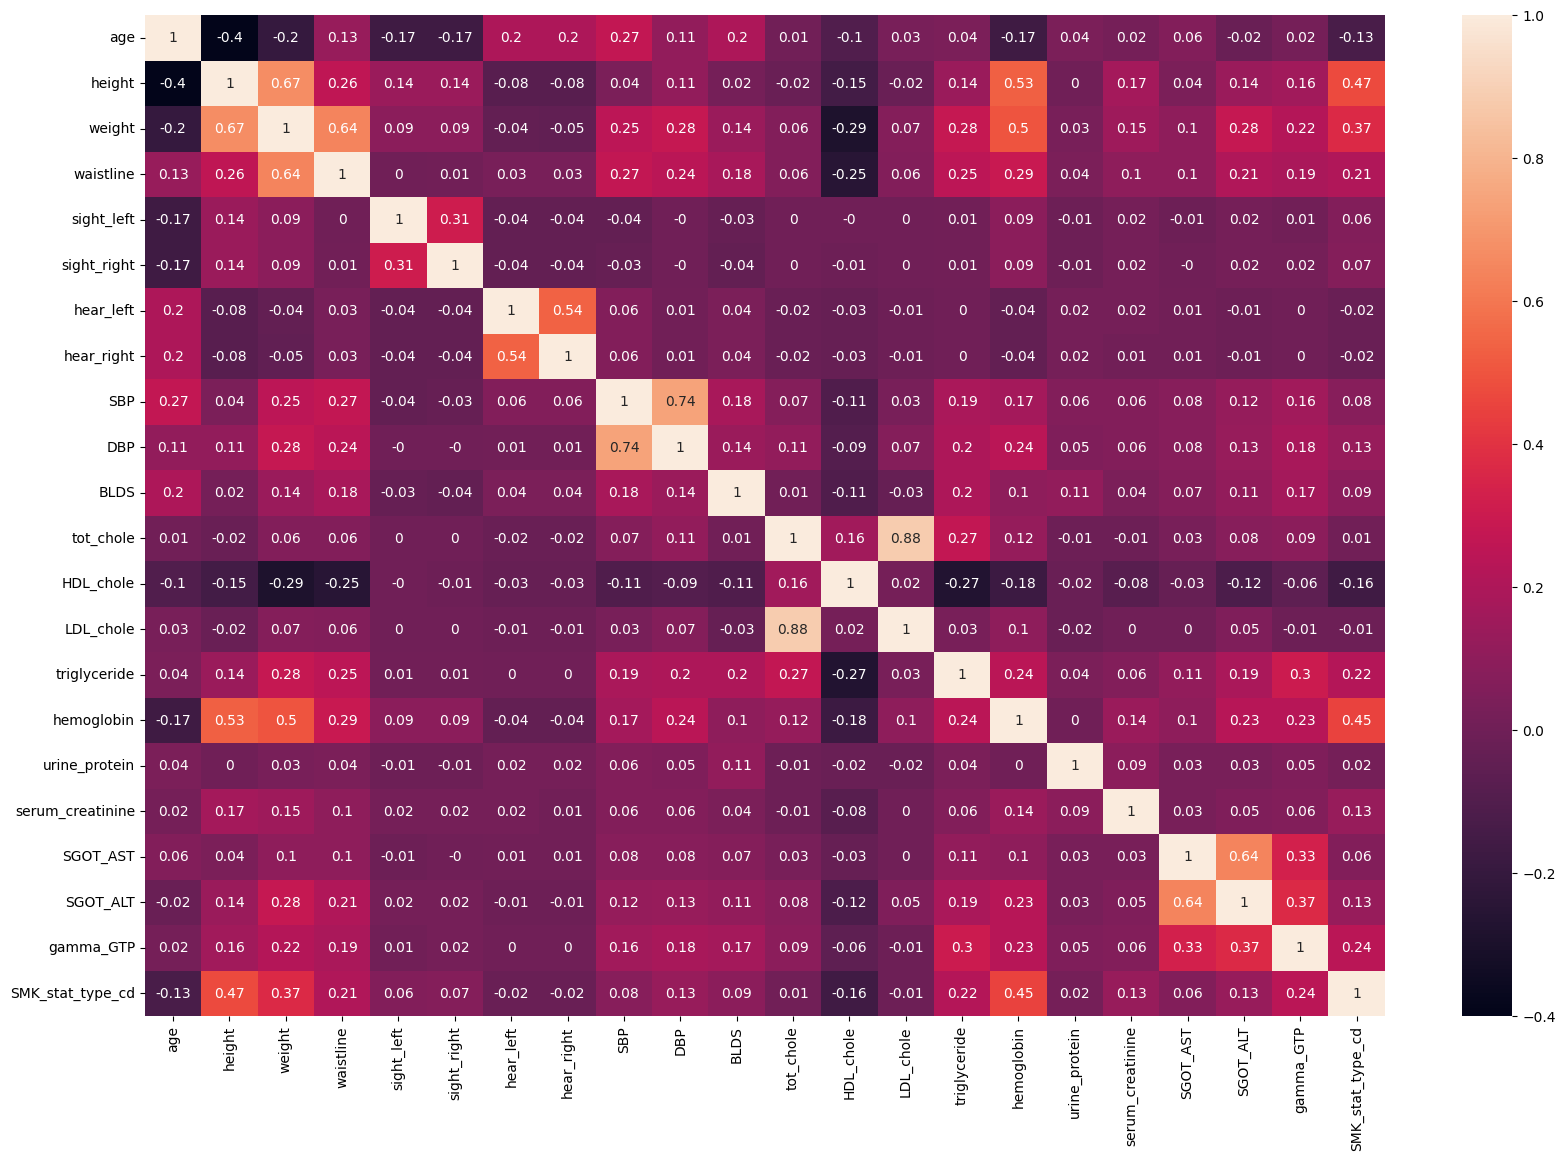

In [ ]:
plt.figure(figsize = (20, 13))
# Convert PySpark DataFrame to Pandas DataFrame before calling corr()
sns.heatmap(round(numeric_df.corr(), 2), annot = True)

Untuk DRK_YN:

* "N" akan diencoding menjadi 0
* "Y" akan diencoding menjadi 1

Untuk sex:

* "Male" akan diencoding menjadi 0
* "Female" akan diencoding menjadi 1

### All the block code above was written by :

* Name : Daffa Hanif Durachman

* NIM : 21.11.4470

# Random Forest

## Create new single vector column is called features.

In [ ]:
numericCols = [
    'sex',
    'age',
    'height',
    'weight',
    'waistline',
    'sight_left',
    'sight_right',
    'hear_left',
    'hear_right',
    'SBP',
    'DBP', # kolom yang ingin digabungkan menjadi satu vektor fitur.
    'BLDS',
    'tot_chole',
    'HDL_chole',
    'LDL_chole',
    'triglyceride',
    'hemoglobin',
    'urine_protein',
    'serum_creatinine',
    'SGOT_AST',
    'SGOT_ALT',
    'gamma_GTP',
    'SMK_stat_type_cd' # tanpa col "DRK_YN"
] # mengambil semua kolom diatas dan menggabungkannya menjadi satu kolom vektor.
assembler = VectorAssembler(inputCols=numericCols, outputCol="features") # dari age - SMK_stat_type_cd jadi satu col di "features"
df = assembler.transform(df)
df.show(5)

+----+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+---+--------------------+
| age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|sex|            features|
+----+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+---+--------------------+
|55.0| 170.0|  70.0|     90.0|       0.9|        0.7|      1.0|       1.0|110.0|80.0| 90.0|    245.0|     77.0|    153.0|        71.0|      13.2|          1.0|             1.2|    25.0|    24.0|     25.0|             1.0|   0.0|0.0|[0.0,5

## String Indexer to encode the string column of species to a column of label indices

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'DRK_YN', outputCol = 'labelIndex')
df = label_stringIdx.fit(df).transform(df)
df.show(5)

+----+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+---+--------------------+----------+
| age|height|weight|waistline|sight_left|sight_right|hear_left|hear_right|  SBP| DBP| BLDS|tot_chole|HDL_chole|LDL_chole|triglyceride|hemoglobin|urine_protein|serum_creatinine|SGOT_AST|SGOT_ALT|gamma_GTP|SMK_stat_type_cd|DRK_YN|sex|            features|labelIndex|
+----+------+------+---------+----------+-----------+---------+----------+-----+----+-----+---------+---------+---------+------------+----------+-------------+----------------+--------+--------+---------+----------------+------+---+--------------------+----------+
|55.0| 170.0|  70.0|     90.0|       0.9|        0.7|      1.0|       1.0|110.0|80.0| 90.0|    245.0|     77.0|    153.0|        71.0|      13.2|          1.0|             1.2|    25.0|    24.0|     25.0| 

## Split our dataset into training and testing data.

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)

## Train and Test Visualization

In [ ]:
print("Training Shape: " + str(train.count()) + " x " + str(len(train.columns)))

Training Shape: 693869 x 26


In [ ]:
print("Test Shape: " + str(test.count()) + " x " + str(len(test.columns)))

Test Shape: 297451 x 26


In [ ]:
train.select("features", "labelIndex").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                         |labelIndex|
+-----------------------------------------------------------------------------------------------------------------+----------+
|[1.0,20.0,140.0,35.0,67.0,0.9,0.5,1.0,1.0,130.0,80.0,107.0,178.0,57.0,105.0,79.0,14.6,1.0,0.7,22.0,15.0,15.0,1.0]|1.0       |
|[1.0,20.0,145.0,35.0,58.0,1.2,1.5,1.0,1.0,101.0,60.0,85.0,139.0,53.0,78.0,39.0,13.1,1.0,0.5,10.0,7.0,9.0,3.0]    |0.0       |
|[1.0,20.0,145.0,40.0,56.0,1.95,1.5,1.0,1.0,100.0,70.0,92.0,121.0,40.0,66.0,75.0,13.0,1.0,0.8,20.0,19.0,11.0,1.0] |0.0       |
|[1.0,20.0,145.0,40.0,59.0,0.5,0.6,1.0,1.0,133.0,75.0,80.0,141.0,54.0,75.0,57.0,13.0,1.0,0.5,17.0,11.0,10.0,1.0]  |0.0       |
|[1.0,20.0,145.0,40.0,59.0,0.5,1.0,1.0,1.0,120.0,83.0,89.0,180.0,58.0,102.0,96.0,13.4,1.0,0.6,23.0,23.0,13.0,1.

In [ ]:
test.select("features", "labelIndex").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                         |labelIndex|
+-----------------------------------------------------------------------------------------------------------------+----------+
|[1.0,20.0,145.0,35.0,66.0,0.1,0.1,1.0,1.0,106.0,61.0,86.0,136.0,64.0,49.0,111.0,14.3,1.0,0.7,16.0,9.0,25.0,3.0]  |1.0       |
|[1.0,20.0,145.0,40.0,59.4,1.5,1.5,1.0,1.0,98.0,66.0,81.0,196.0,75.0,109.0,59.0,13.6,1.0,0.6,18.0,12.0,14.0,1.0]  |1.0       |
|[1.0,20.0,145.0,40.0,60.0,0.8,1.0,1.0,1.0,130.0,80.0,97.0,174.0,54.0,110.0,50.0,12.6,1.0,0.9,14.0,5.0,14.0,1.0]  |0.0       |
|[1.0,20.0,145.0,40.0,60.0,1.0,1.0,1.0,1.0,118.0,76.0,108.0,140.0,72.0,57.0,53.0,14.3,1.0,0.8,18.0,15.0,28.0,2.0] |0.0       |
|[1.0,20.0,145.0,40.0,61.0,1.2,1.0,1.0,1.0,110.0,80.0,127.0,154.0,75.0,66.0,67.0,13.4,1.0,0.9,23.0,13.0,15.0,1.

## Applying Random Forest Classifier

In [ ]:
rf = RF(featuresCol = 'features', labelCol = 'labelIndex', numTrees=20, seed=42) # Random Forest sudah dialiasi as RF pada saat load library
rfModel = rf.fit(train)
rf_predictions = rfModel.transform(test)
rf_predictions.select("prediction", "labelIndex", "features").show(10)

+----------+----------+--------------------+
|prediction|labelIndex|            features|
+----------+----------+--------------------+
|       1.0|       1.0|[1.0,20.0,145.0,3...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
|       0.0|       0.0|[1.0,20.0,145.0,4...|
|       1.0|       0.0|[1.0,20.0,145.0,4...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
|       0.0|       0.0|[1.0,20.0,145.0,4...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
|       0.0|       0.0|[1.0,20.0,145.0,4...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
+----------+----------+--------------------+
only showing top 10 rows



## Evaluate model.

In [ ]:
# Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="f1"
)

# Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

accuracy = evaluator_accuracy.evaluate(rf_predictions)
f1 = evaluator_f1.evaluate(rf_predictions)
precision = evaluator_precision.evaluate(rf_predictions)

print(f"Accuracy = {accuracy:.4f}")
print(f"F1 Score = {f1:.4f}")
print(f"Precision = {precision:.4f}")
print(f"Test Error = {1.0 - accuracy:.4f}")

Accuracy = 0.7106
F1 Score = 0.7106
Precision = 0.7107
Test Error = 0.2894


## RF Confusion matrix

In [ ]:
preds_and_labels = rf_predictions.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
# Instead of printing, assign the result to a variable:
confusion_matrix_rf = metrics.confusionMatrix().toArray()
print(confusion_matrix_rf)  # Now you can print the confusion matrix

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[104671.  44140.]
 [ 41938. 106702.]]


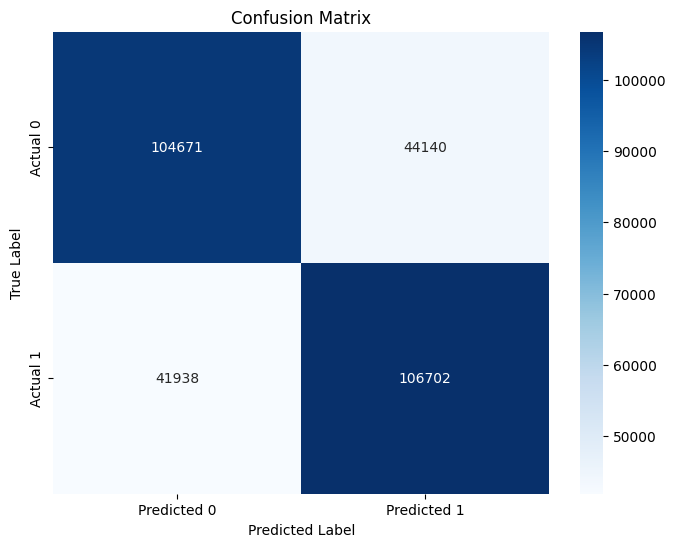

In [ ]:
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# AUC (ROC Curve) Random Forest

In [ ]:
# Inisialisasi evaluator
rf_evaluator = BinaryClassificationEvaluator(
    labelCol="labelIndex",  # kolom label asli
    rawPredictionCol="rawPrediction",  # kolom prediksi probabilitas
    metricName="areaUnderROC"
)

# Hitung AUC Score
aucrf_score = rf_evaluator.evaluate(rf_predictions)
print(f"Area Under ROC: {aucrf_score:.4f}")

Area Under ROC: 0.7891


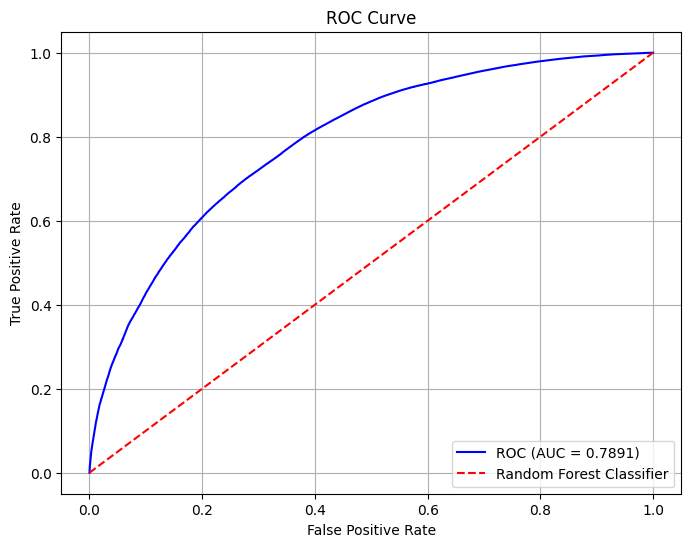

In [ ]:
# Ambil probability untuk class 1 dan label actual
predrf_pd = rf_predictions.select(['probability', 'labelIndex']) \
    .toPandas()

# Extract probability untuk class positif (index 1)
yrf_score = np.array([prob[1] for prob in predrf_pd['probability']])
yrf_true = predrf_pd['labelIndex']

# Hitung ROC Curve menggunakan scikit-learn
fpr, tpr, thresholds = roc_curve(yrf_true, yrf_score)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {aucrf_score:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

All the block code above was written by :

* Name : Daffa Hanif D.

* NIM : 21.11.4470

# Gradient Boost Tree

## Applying GBT

In [ ]:
gb = GBT(featuresCol = 'features', labelCol = 'labelIndex', maxIter=10)
gbModel = gb.fit(train)
gb_predictions = gbModel.transform(test)
gb_predictions.select('prediction', 'labelIndex', 'features').show(10)

+----------+----------+--------------------+
|prediction|labelIndex|            features|
+----------+----------+--------------------+
|       1.0|       1.0|[1.0,20.0,145.0,3...|
|       1.0|       1.0|[1.0,20.0,145.0,4...|
|       1.0|       0.0|[1.0,20.0,145.0,4...|
|       1.0|       0.0|[1.0,20.0,145.0,4...|
|       1.0|       1.0|[1.0,20.0,145.0,4...|
|       1.0|       1.0|[1.0,20.0,145.0,4...|
|       1.0|       0.0|[1.0,20.0,145.0,4...|
|       1.0|       1.0|[1.0,20.0,145.0,4...|
|       1.0|       0.0|[1.0,20.0,145.0,4...|
|       0.0|       1.0|[1.0,20.0,145.0,4...|
+----------+----------+--------------------+
only showing top 10 rows



## Evaluate GBT

In [ ]:
# Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="f1"
)

# Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

accuracy = evaluator_accuracy.evaluate(gb_predictions)
f1 = evaluator_f1.evaluate(gb_predictions)
precision = evaluator_precision.evaluate(gb_predictions)

print(f"Accuracy = {accuracy:.4f}")
print(f"F1 Score = {f1:.4f}")
print(f"Precision = {precision:.4f}")
print(f"Test Error = {1.0 - accuracy:.4f}")

Accuracy = 0.7289
F1 Score = 0.7288
Precision = 0.7291
Test Error = 0.2711


## GBT Confusion Matrix

In [ ]:
preds_and_labels = gb_predictions.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
# Instead of printing, assign the result to a variable:
confusion_matrix_gbt = metrics.confusionMatrix().toArray()
print(confusion_matrix_gbt)  # Now you can print the confusion matrix

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[106169.  42642.]
 [ 37995. 110645.]]


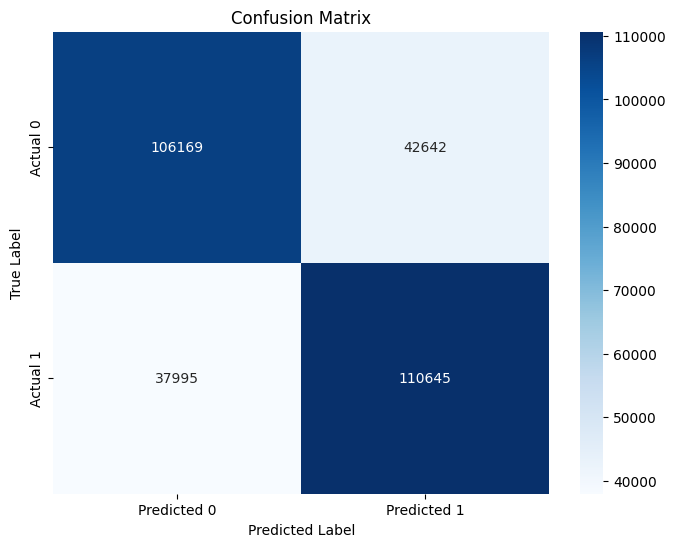

In [ ]:
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_gbt, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## AUC(ROC Curve) of GBT

In [ ]:
# Inisialisasi evaluator
gb_evaluator = BinaryClassificationEvaluator(
    labelCol="labelIndex",  # kolom label asli
    rawPredictionCol="rawPrediction",  # kolom prediksi probabilitas
    metricName="areaUnderROC"
)

# Hitung AUC Score
aucgb_score = gb_evaluator.evaluate(gb_predictions)
print(f"Area Under ROC: {aucgb_score:.4f}")

Area Under ROC: 0.8083


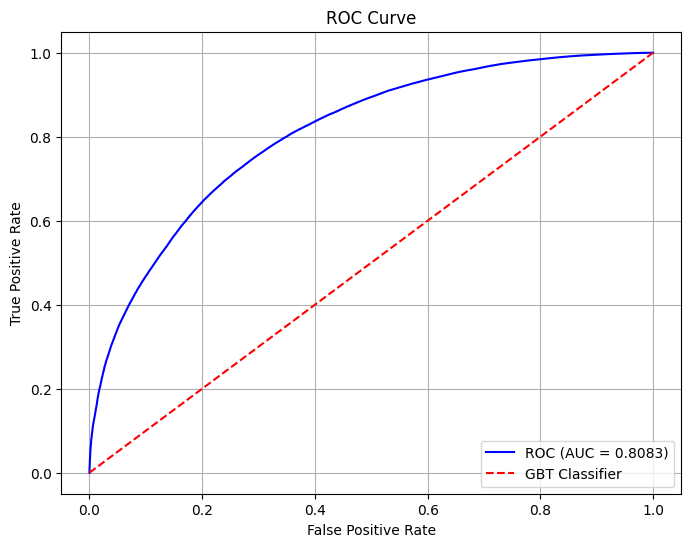

In [ ]:
# Ambil probability untuk class 1 dan label actual
predgb_pd = gb_predictions.select(['probability', 'labelIndex']) \
    .toPandas()

# Extract probability untuk class positif (index 1)
ygb_score = np.array([prob[1] for prob in predgb_pd['probability']])
ygb_true = predgb_pd['labelIndex']

# Step 3: Hitung ROC Curve menggunakan scikit-learn
fpr, tpr, thresholds = roc_curve(ygb_true, ygb_score)

# Step 4: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {aucgb_score:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label= 'GBT Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

All the block code above was written by :
* Name : Daffa Hanif D.
* NIM : 21.11.4470

# Naive Bayes

## Naive bayes drinking model

In [ ]:
from pyspark.ml.classification import NaiveBayes
# Initialize the Naive Bayes model
nb_drk = NaiveBayes(featuresCol="features", labelCol="labelIndex", smoothing=1.0)

# Train the model
model_nb_drk = nb_drk.fit(train)

# Make predictions
predictions_nb_drk = model_nb_drk.transform(test)

## naive bayes drinking model precision, recall, f1-score, accuracy, dan auc

In [ ]:
precision_evaluator_nb_drk = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator_nb_drk = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator_nb_drk = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="f1"
)
accuracy_evaluator_nb_drk = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy"
)
auc_evaluator_nb = BinaryClassificationEvaluator(
    labelCol="labelIndex", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

# Compute metrics
precision_nb_drk = precision_evaluator_nb_drk.evaluate(predictions_nb_drk)
recall_nb_drk = recall_evaluator_nb_drk.evaluate(predictions_nb_drk)
f1_score_nb_drk = f1_evaluator_nb_drk.evaluate(predictions_nb_drk)
accuracy_nb_drk = accuracy_evaluator_nb_drk.evaluate(predictions_nb_drk)
auc_nb = auc_evaluator_nb.evaluate(predictions_nb_drk)

# Print the results
print(f"Classification Report Drinking Model:")
print(f"Precision: {precision_nb_drk:.4f}")
print(f"Recall: {recall_nb_drk:.4f}")
print(f"F1-Score: {f1_score_nb_drk:.4f}")
print(f"Accuracy: {accuracy_nb_drk:.4f}")
print(f"Area Under ROC: {auc_nb:.4f}")

Classification Report Drinking Model:
Precision: 0.6446
Recall: 0.6402
F1-Score: 0.6374
Accuracy: 0.6402
Area Under ROC: 0.4104


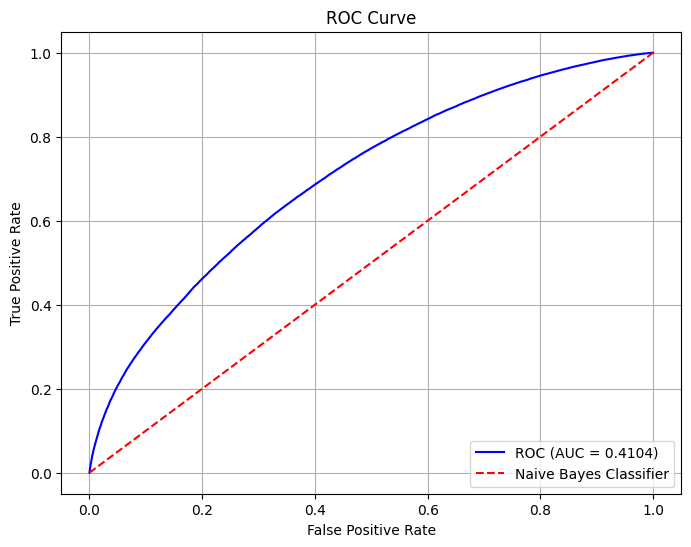

In [ ]:
# Ambil probability untuk class 1 dan label actual
prednb_pd = predictions_nb_drk.select(['probability', 'labelIndex']) \
    .toPandas()

# Extract probability untuk class positif (index 1)
ynb_score = np.array([prob[1] for prob in prednb_pd['probability']])
ynb_true = prednb_pd['labelIndex']

# Step 3: Hitung ROC Curve menggunakan scikit-learn
fpr, tpr, thresholds = roc_curve(ynb_true, ynb_score)

# Step 4: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {auc_nb:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label= 'Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## naive bayes drinking model confusion matrix

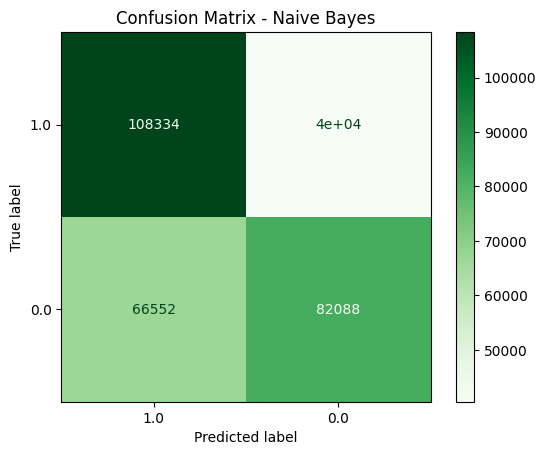

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualize Confusion Matrix for Drinking Habit (Naive Bayes)
predictions_nb_drk_pd = predictions_nb_drk.select("labelIndex", "prediction").toPandas()
unique_labels_nb_drk = predictions_nb_drk_pd["labelIndex"].unique()

conf_matrix_nb_drk = confusion_matrix(predictions_nb_drk_pd["labelIndex"], predictions_nb_drk_pd["prediction"])
disp_nb_drk = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nb_drk, display_labels=unique_labels_nb_drk)

disp_nb_drk.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

All the block code above was written by :

Name :Ramadhani Reza Saeputra

NIM : 22.11.5266

# XGBoost




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


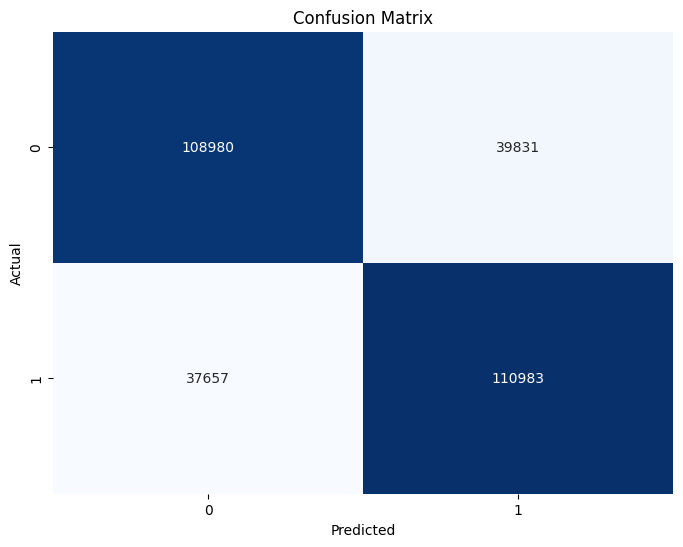

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.74    148811
         1.0       0.74      0.75      0.74    148640

    accuracy                           0.74    297451
   macro avg       0.74      0.74      0.74    297451
weighted avg       0.74      0.74      0.74    297451



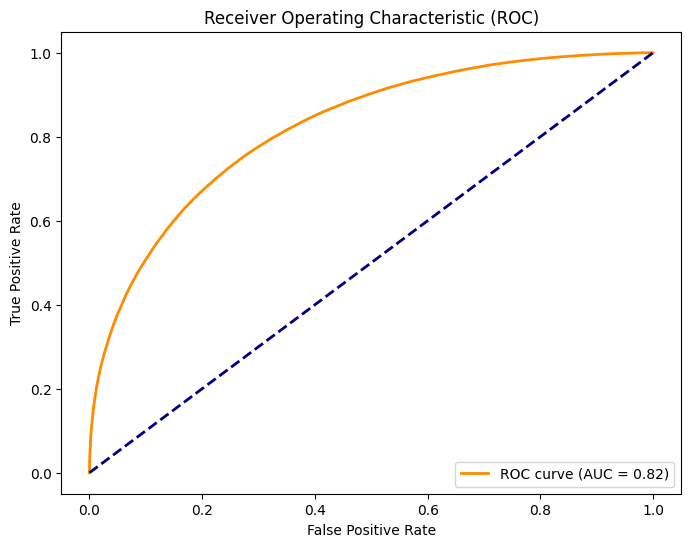

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi data Spark ke Pandas
train_df = train.select("features", "labelIndex").toPandas()
test_df = test.select("features", "labelIndex").toPandas()

# Pisahkan fitur dan labelIndex
X_train = list(train_df['features'])
y_train = train_df['labelIndex']
X_test = list(test_df['features'])
y_test = test_df['labelIndex']

# Train an XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# Evaluasi model
accuracy = xgb.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# sparkxgbc = SparkXGBClassifier(features_col="features", label_Col="labelIndex", numRound=10)
# model_xgbc = sparkxgbc.fit(train)
# predictions_xgbc = model_xgbc.transform(test)

In [ ]:
# precision_evaluator_xgbc = MulticlassClassificationEvaluator(
#     labelCol="labelIndex", predictionCol="prediction", metricName="weightedPrecision"
# )
# recall_evaluator_xgbc = MulticlassClassificationEvaluator(
#     labelCol="labelIndex", predictionCol="prediction", metricName="weightedRecall"
# )
# f1_evaluator_xgbc = MulticlassClassificationEvaluator(
#     labelCol="labelIndex", predictionCol="prediction", metricName="f1"
# )
# accuracy_evaluator_xgbc = MulticlassClassificationEvaluator(
#     labelCol="labelIndex", predictionCol="prediction", metricName="accuracy"
# )
# auc_evaluator_xgbc = BinaryClassificationEvaluator(
#     labelCol="labelIndex", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
# )

# precision_xgbc = precision_evaluator_xgbc.evaluate(predictions_xgbc)
# recall_xgbc = recall_evaluator_xgbc.evaluate(predictions_xgbc)
# f1_score_xgbc = f1_evaluator_xgbc.evaluate(predictions_xgbc)
# accuracy_xgbc = accuracy_evaluator_xgbc.evaluate(predictions_xgbc)
# auc_xgbc = auc_evaluator_xgbc.evaluate(predictions_xgbc)

# print(f"Classification Report XGBoost:")
# print(f"Precision: {precision_xgbc:.4f}")
# print(f"Recall: {recall_xgbc:.4f}")
# print(f"F1-Score: {f1_score_xgbc:.4f}")
# print(f"Accuracy: {accuracy_xgbc:.4f}")
# print(f"Area Under ROC: {auc_xgbc:.4f}")

In [ ]:
# predrf_pd = rf_predictions.select(['probability', 'labelIndex']).toPandas()

# # Extract probability untuk class positif (index 1)
# yrf_score = np.array([prob[1] for prob in predrf_pd['probability']])
# yrf_true = predrf_pd['labelIndex']

# # Hitung ROC Curve menggunakan scikit-learn
# fpr, tpr, thresholds = roc_curve(yrf_true, yrf_score)

# # Plot ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {aucrf_score:.4f})')
# plt.plot([0, 1], [0, 1], 'r--', label='Random Forest Classifier')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

In [ ]:
# # Assuming 'predictions_xgbc' is your Spark DataFrame with predictions
# preds_and_labels = predictions_xgbc.select(['prediction', 'labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
# preds_and_labels = preds_and_labels.select(['prediction', 'labelIndex'])
# metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# confusion_matrix_xgbc = metrics.confusionMatrix().toArray()
# print(confusion_matrix_xgbc)

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix_xgbc, annot=True, fmt=".0f", cmap="Blues",
#             xticklabels=["Predicted 0", "Predicted 1"],
#             yticklabels=["Actual 0", "Actual 1"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for XGBoost")
# plt.show()

## All the block code above was written by :

Name : Daffa Hanif Durachman

NIM : 21.11.4470

# Hyperparameter Tuning

2 model dengan performa terbaik

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Inisialisasi model XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist')

# Definisikan grid parameter untuk tuning
param_grid = {
    'n_estimators': [50, 100, 200],   # Jumlah pohon keputusan
    'max_depth': [3, 5, 7],           # Kedalaman maksimum pohon
    'learning_rate': [0.01, 0.1, 0.3], # Kecepatan belajar
    'subsample': [0.7, 0.8, 1.0],      # Sampling data sebelum membangun pohon
    'colsample_bytree': [0.7, 0.8, 1.0] # Sampling fitur untuk setiap pohon
}

# Lakukan Grid Search dengan cross-validation (3-fold CV)
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Dapatkan parameter terbaik
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Training Accuracy:", grid_search.best_score_)

# Evaluasi pada data test menggunakan model terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi lengkap
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Hyperparameter tuning for gradient boost tree
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid_gb = (ParamGridBuilder()
             .addGrid(gb.maxIter, [10, 20])
             .addGrid(gb.maxDepth, [5, 10])
             .build())

crossval_gb = CrossValidator(estimator=gb,
                          estimatorParamMaps=paramGrid_gb,
                          evaluator=BinaryClassificationEvaluator(labelCol="labelIndex"),
                          numFolds=2,
                          parallelism=2)

cvModel_gb = crossval_gb.fit(train)
bestModel_gb = cvModel_gb.bestModel

# Make predictions with the best model
gb_predictions = bestModel_gb.transform(test)

# Evaluate the best model
accuracy_gb = evaluator_accuracy.evaluate(gb_predictions)
f1_gb = evaluator_f1.evaluate(gb_predictions)
precision_gb = evaluator_precision.evaluate(gb_predictions)
auc_gb = gb_evaluator.evaluate(gb_predictions)


print(f"Best GBT - Accuracy = {accuracy_gb:.4f}")
print(f"Best GBT - F1 Score = {f1_gb:.4f}")
print(f"Best GBT - Precision = {precision_gb:.4f}")
print(f"Best GBT - Area Under ROC: {auc_gb:.4f}")

Referensi :